In [3]:
import os
import numpy as np
import pandas as pd
import trackml
from trackml.dataset import load_event
from trackml.dataset import load_dataset

In [4]:
from matplotlib import pyplot as plt
import matplotlib.pylab as pl
plt.rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size':10})

# Set the font used for MathJax - more on this later
plt.rc('mathtext',**{'default':'regular'})

In [5]:
def calc_dphi(phi1, phi2):
    """Computes phi2-phi1 given in range [-pi,pi]"""
    dphi = phi2 - phi1
    dphi[dphi > np.pi] -= 2*np.pi
    dphi[dphi < -np.pi] += 2*np.pi
    return dphi

def calc_eta(r, z):
    theta = np.arctan2(r, z)
    return -1. * np.log(np.tan(theta / 2.))

In [6]:
pixel_layers = [(8,2), (8,4), (8,6), (8,8),
                (7,14), (7,12), (7,10),
                (7,8), (7,6), (7,4), (7,2),
                (9,2), (9,4), (9,6), (9,8),
                (9,10), (9,12), (9,14)]

layer_pairs = [(0,1), (1,2), (2,3), 
               (0,4), (1,4), (2,4),
               (4,5), (5,6), (6,7), (7,8), (8,9), (9,10),
               (0,11), (1,11), (2,11),
               (11,12), (12,13), (13,14), (14,15), (15,16), (16,17)]

#pixel_layers = [(8,2), (8,4), (8,6), (8,8),
#                (7,2), (7,4), (7,6), (7,8),
#                (7,10), (7,12), (7,14),
#                (9,2), (9,4), (9,6), (9,8),
#                (9,10), (9,12), (9,14)]

#layer_pairs = [(0,1), (1,2), (2,3), 
#               (0,10), (1,10), (2,10),
#               (4,5), (5,6), (6,7), (7,8), (8,9), (9,10),
#               (0,11), (1,11), (2,11),
#               (11,12), (12,13), (13,14), (14,15), (15,16), (16,17)]

In [7]:
pt_min = 0.5
indir = '/tigress/jdezoort/train_1'
evtid = 'event000001160'
hits, cells, particles, truth = load_event(os.path.join(indir, evtid))
hits_by_loc = hits.groupby(['volume_id', 'layer_id'])
hits = pd.concat([hits_by_loc.get_group(pixel_layers[i]).assign(layer=i)
                  for i in range(len(pixel_layers))])

module_labels = {}

print(hits.columns)
print(truth.columns)
print(particles.columns)
print(np.unique(hits['layer'].values))
for lid, lhits in hits.groupby('layer'):
    module_labels[lid] = np.unique(lhits['module_id'].values)

#print(module_labels)

Index(['hit_id', 'x', 'y', 'z', 'volume_id', 'layer_id', 'module_id', 'layer'], dtype='object')
Index(['hit_id', 'particle_id', 'tx', 'ty', 'tz', 'tpx', 'tpy', 'tpz',
       'weight'],
      dtype='object')
Index(['particle_id', 'vx', 'vy', 'vz', 'px', 'py', 'pz', 'q', 'nhits'], dtype='object')
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]


In [8]:
pt = np.sqrt(particles.px**2 + particles.py**2)
particles['pt'] = pt
particles = particles[pt > pt_min]

truth = (truth[['hit_id', 'particle_id']]
         .merge(particles[['particle_id', 'pt']], on='particle_id'))

r = np.sqrt(hits.x**2 + hits.y**2)
phi = np.arctan2(hits.y, hits.x)

hits = (hits[['hit_id', 'z', 'layer', 'module_id']]
        .assign(r=r, phi=phi)
        .merge(truth[['hit_id', 'particle_id', 'pt']], on='hit_id'))

#hits = (hits.loc[
#    hits.groupby(['particle_id', 'layer'], as_index=False).r.idxmin()
#]).assign(evtid=-1)
hits = hits.assign(evtid=-1)

(0, 1) (225, 449) 101025
(1, 2) (449, 728) 326872
(2, 3) (728, 1093) 795704
(0, 4) (225, 109) 24525
(1, 4) (449, 109) 48941
(2, 4) (728, 109) 79352
(4, 5) (109, 109) 11881
(5, 6) (109, 109) 11881
(6, 7) (109, 109) 11881
(7, 8) (109, 109) 11881
(8, 9) (109, 109) 11881
(9, 10) (109, 109) 11881
(0, 11) (225, 109) 24525
(1, 11) (449, 109) 48941
(2, 11) (728, 109) 79352
(11, 12) (109, 109) 11881
(12, 13) (109, 109) 11881
(13, 14) (109, 109) 11881
(14, 15) (109, 109) 11881
(15, 16) (109, 109) 11881
(16, 17) (109, 109) 11881
1671809


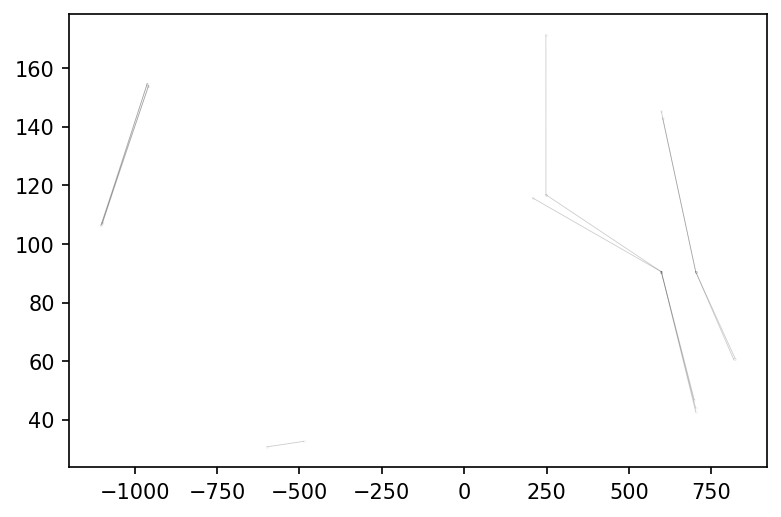

In [9]:
module_maps = {(i,j): np.zeros((np.max(module_labels[i])+1, np.max(module_labels[j])+1))
               for (i,j) in layer_pairs}

total_connections = 0
for ids, module_map in module_maps.items():
    print(ids, module_map.shape, module_map.shape[0]*module_map.shape[1])
    total_connections += module_map.shape[0]*module_map.shape[1]
    
print(total_connections)

offending_pids = []
hits_by_loc = hits.groupby('layer')
fig = plt.figure(dpi=150)
for lp in layer_pairs:
    hits0 = hits_by_loc.get_group(lp[0])
    hits1 = hits_by_loc.get_group(lp[1])
    
    keys = ['evtid', 'particle_id', 'module_id', 'r', 'phi', 'z']
    hit_pairs = hits0[keys].reset_index().merge(
        hits1[keys].reset_index(), on='evtid', suffixes=('_1', '_2'))
    pid1, pid2 = hit_pairs['particle_id_1'].values, hit_pairs['particle_id_2'].values
    hit_pairs = hit_pairs[pid1==pid2]
    pid1, pid2 = hit_pairs['particle_id_1'].values, hit_pairs['particle_id_2'].values
    mid1, mid2 = hit_pairs['module_id_1'].values, hit_pairs['module_id_2'].values
    r1, r2 = hit_pairs['r_1'].values, hit_pairs['r_2'].values
    z1, z2 = hit_pairs['z_1'].values, hit_pairs['z_2'].values
    slope = (r2-r1)/(z2-z1)
    for i in range(len(mid1)):
        if (slope[i]*z1[i] < 0) and (slope[i]*z2[i] < 0) and (abs(z1[i]) > 20 or abs(z2[i]) > 20): 
            offending_pids.append(pid1[i])
            plt.plot((z1[i], z2[i]), (r1[i], r2[i]),
                      marker='o', ls='-', color='black', 
                      lw=0.4, ms=0.1, alpha=0.2)
            
        module_maps[lp][mid1[i]][mid2[i]]+=1
        
plt.show()

       hit_id           z  layer  module_id           r       phi  \
2065    16761   42.371399      0        128   31.925585  2.910501   
4540    22975  107.608002      1        287   71.667717  2.928098   
6624    28613  180.565994      2        519  115.936905  2.949344   
8369    33780  272.376007      3        856  171.492706  2.976147   
8371    33783  275.665009      3        857  173.481934  2.977129   
14077   36811  602.000000     11        103  143.006332  2.871426   
14101   36877  598.000000     11        105  145.259033  2.877583   
14929   38998  702.500000     12         98   90.467590  2.604121   
15704   40920  822.000000     13         82   60.874050  1.682170   
15736   40985  817.500000     13         85   60.595104  1.726783   
16414   42727  962.000000     14         69  111.553970  0.835825   
16418   42739  958.000000     14         70  109.472496  0.847087   

            particle_id        pt  evtid  
2065   4506485845393408  0.636687     -1  
4540   450648584

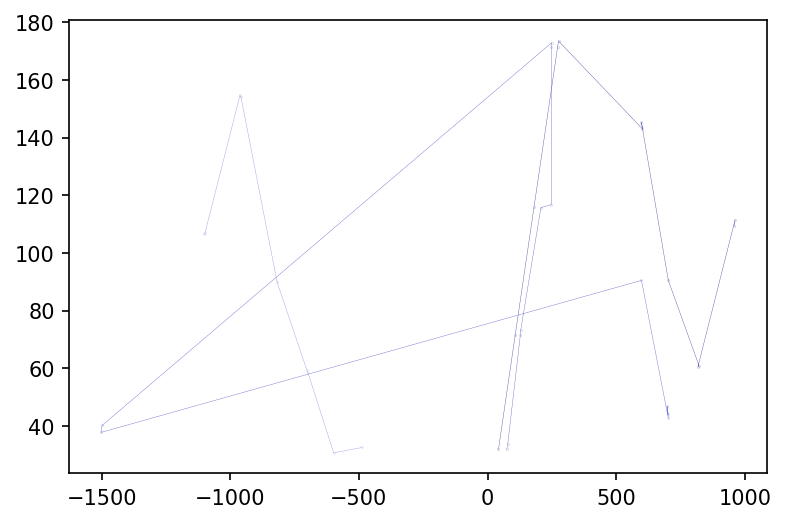

In [10]:
from matplotlib import cm 
cmap = cm.get_cmap('tab20b')

fig = plt.figure(dpi=150)
counter = 0
for pid, pid_hits in hits[hits.particle_id.isin(offending_pids)].groupby('particle_id'):
    counter += 1
    print(pid_hits)
    plt.plot(pid_hits['z'].values, pid_hits['r'],
             marker='o', ls='-', color=cmap(counter%25), 
             lw=0.2, ms=0.1, alpha=1)
    
print(counter)
#plt.xlim([-50, 50])
plt.show()

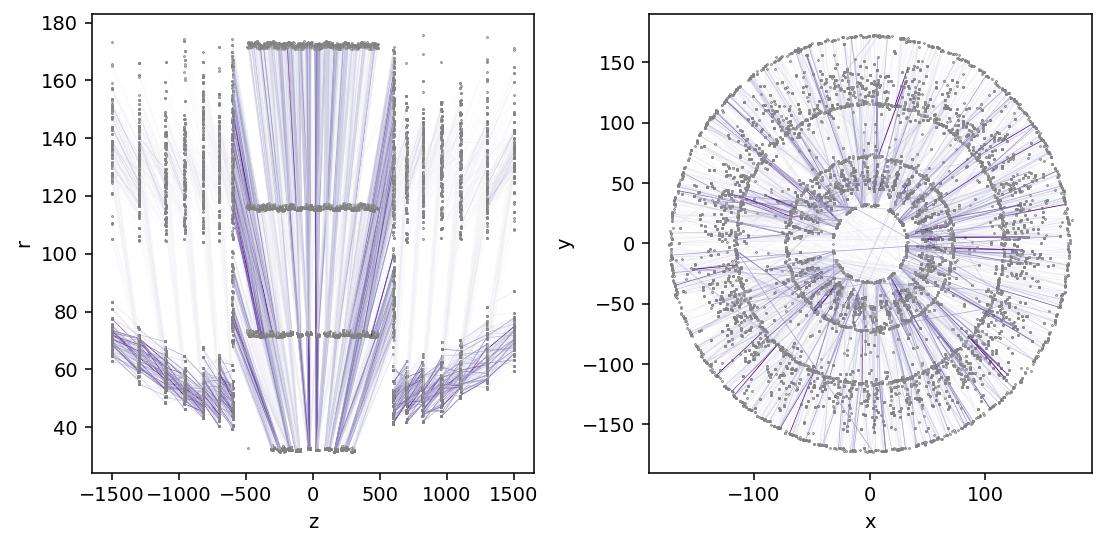

In [11]:
from matplotlib import cm 
hits_by_loc = hits.groupby('layer')

fig, axs = plt.subplots(nrows=1, ncols=2, dpi=140, figsize=(8,4))
cmap = cm.get_cmap('Purples', 25)

max_counts = []
for lp in layer_pairs:
    module_map = module_maps[lp]
    max_counts.append(np.max(module_map))

max_count = np.max(max_counts)
    
for lp in layer_pairs:

    hits0 = hits_by_loc.get_group(lp[0])
    hits1 = hits_by_loc.get_group(lp[1])
    keys = ['evtid', 'particle_id', 'module_id', 'r', 'phi', 'z']
    hit_pairs = hits0[keys].reset_index().merge(
    hits1[keys].reset_index(), on='evtid', suffixes=('_1', '_2'))
    pid1, pid2 = hit_pairs['particle_id_1'], hit_pairs['particle_id_2']
    hit_pairs = hit_pairs[pid1==pid2]
    mid1, mid2 = hit_pairs['module_id_1'].values, hit_pairs['module_id_2'].values
    r1, r2 = hit_pairs['r_1'], hit_pairs['r_2']
    p1, p2 = hit_pairs['phi_1'], hit_pairs['phi_2']
    z1, z2 = hit_pairs['z_1'], hit_pairs['z_2']
    
    module_map = module_maps[lp]
    max_count = np.max(module_map)
    for i in np.unique(mid1):
        for j in np.unique(mid2):
            if module_map[(i,j)] == 0: continue
            r1avg = np.mean(r1[mid1==i])
            r2avg = np.mean(r2[mid2==j])
            p1avg = np.mean(p1[mid1==i])
            p2avg = np.mean(p2[mid2==j])
            z1avg = np.mean(z1[mid1==i])
            z2avg = np.mean(z2[mid2==j])
            
            weight = module_map[(i,j)]/max_count
            axs[0].plot((z1avg, z2avg), (r1avg, r2avg),
                         marker='o', ls='-', color=cmap(weight), 
                         lw=0.4, ms=0.1, alpha=weight)
            axs[1].plot((r1avg*np.cos(p1avg), r2avg*np.cos(p2avg)), 
                        (r1avg*np.sin(p1avg), r2avg*np.sin(p2avg)),
                         marker='o', ls='-', color=cmap(weight), 
                         lw=0.4, ms=0.1, alpha=weight)
           
            axs[0].plot(z1avg, r1avg, marker='o', ms=0.4, color='grey')
            axs[0].plot(z2avg, r2avg, marker='o', ms=0.4, color='grey')
            axs[1].plot(r1avg*np.cos(p1avg), r1avg*np.sin(p1avg), marker='o', ms=0.4, color='grey')
            axs[1].plot(r2avg*np.cos(p2avg), r2avg*np.sin(p2avg), marker='o', ms=0.4, color='grey')
    
axs[0].set_xlabel('z')
axs[0].set_ylabel('r')
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')
plt.tight_layout()
plt.show()

In [ ]:
%matplotlib notebook
from matplotlib import cm 
hits_by_loc = hits.groupby('layer')

fig = plt.figure(dpi=140)
ax = plt.axes(projection='3d')
cmap = cm.get_cmap('magma', 25)
for lp in layer_pairs:

    hits0 = hits_by_loc.get_group(lp[0])
    hits1 = hits_by_loc.get_group(lp[1])
    keys = ['evtid', 'particle_id', 'module_id', 'r', 'phi', 'z']
    hit_pairs = hits0[keys].reset_index().merge(
        hits1[keys].reset_index(), on='evtid', suffixes=('_1', '_2'))
    pid1, pid2 = hit_pairs['particle_id_1'], hit_pairs['particle_id_2']
    hit_pairs = hit_pairs[pid1==pid2]
    mid1, mid2 = hit_pairs['module_id_1'].values, hit_pairs['module_id_2'].values
    r1, r2 = hit_pairs['r_1'], hit_pairs['r_2']
    p1, p2 = hit_pairs['phi_1'], hit_pairs['phi_2']
    z1, z2 = hit_pairs['z_1'], hit_pairs['z_2']
    
    module_map = module_maps[lp]
    max_count = np.max(module_map)
    for i in np.unique(mid1):
        for j in np.unique(mid2):
            if module_map[(i,j)] == 0: continue
            r1avg = np.mean(r1[mid1==i])
            r2avg = np.mean(r2[mid2==j])
            p1avg = np.mean(p1[mid1==i])
            p2avg = np.mean(p2[mid2==j])
            z1avg = np.mean(z1[mid1==i])
            z2avg = np.mean(z2[mid2==j])
            weight = module_map[(i,j)]/max_count
            ax.plot3D((z1avg, z2avg),
                      (r1avg*np.sin(p1avg), r2avg*np.sin(p2avg)),
                      (r1avg*np.cos(p1avg), r2avg*np.cos(p2avg)), 
                       marker='o', ls='-', color=cmap(weight), 
                       lw=0.4, ms=0.1, alpha=weight)
            ax.set_xlabel('z')
            ax.set_ylabel('y')
            ax.set_zlabel('x')
            ax.plot3D(z1avg, r1avg*np.cos(p1avg), r1avg*np.sin(p1avg), marker='o', ms=0.4, color='grey')
            ax.plot3D(z2avg, r2avg*np.cos(p2avg), r2avg*np.sin(p2avg), marker='o', ms=0.4, color='grey')
    
plt.show()

In [ ]:
# outer merge keeps noise hits (with particle_id=0)
truth = (truth[['hit_id', 'particle_id', 'weight']]
         .merge(particles[['particle_id']], on='particle_id'))

# cylindrical r, detector phi and eta, conformal u and v
r = np.sqrt(hits.x**2 + hits.y**2)
eta = np.arctanh(hits.z/np.sqrt(hits.z**2 + r**2))
phi = np.arctan2(hits.y, hits.x)
u = hits.x/(hits.x**2 + hits.y**2)
v = hits.y/(hits.x**2 + hits.y**2)

hits = (hits[['hit_id', 'x', 'y', 'z', 'layer']]
        .assign(r=r, eta=eta, phi=phi, u=u, v=v)
        .merge(truth[['hit_id', 'particle_id']], on='hit_id'))

pt = np.sqrt(particles.px**2 + particles.py**2)
particles['pt'] = pt

particles_ptcut = np.unique(particles[pt > pt_cut].particle_id)
hits = hits[hits['particle_id'].isin(particles_ptcut)]
u, v = hits['u'], hits['v']
eta, phi = hits['eta'], hits['phi']

# relabel particle_ids
n_particles = particles_ptcut.shape[0]
label_map = {particles_ptcut[i]: i for i in range(n_particles)}
hits['particle_id'] = hits.particle_id.map(label_map)
hits['evtid'] = [evtid for _ in range(len(hits))]
hits['eta'] = calc_eta(hits.r, hits.z)
particles['particle_id'] = particles.particle_id.map(label_map)

In [ ]:
phi_slope_max, z0_max = 0.000763, 15000
for (layer1, layer2) in layer_pairs:
    print("Evalulating {}-{} hits".format(layer1, layer2))
    hits1 = hits[hits.layer==layer1]
    hits2 = hits[hits.layer==layer2]
    
    keys = ['evtid', 'r', 'phi', 'z', 'eta']
    hit_pairs = hits1[keys].reset_index().merge(
        hits2[keys].reset_index(), on='evtid', suffixes=('_1', '_2'))

    # Compute line through the points
    dphi = calc_dphi(hit_pairs.phi_1, hit_pairs.phi_2)
    dz = hit_pairs.z_2 - hit_pairs.z_1
    dr = hit_pairs.r_2 - hit_pairs.r_1
    #eta_1 = calc_eta(hit_pairs.r_1, hit_pairs.z_1)
    #eta_2 = calc_eta(hit_pairs.r_2, hit_pairs.z_2)
    deta = hit_pairs.eta_2 - hit_pairs.eta_1
    dR = np.sqrt(deta**2 + dphi**2)
    phi_slope = dphi / dr
    z0 = hit_pairs.z_1 - hit_pairs.r_1 * dz / dr
    
    # Filter segments according to criteria
    good_seg_mask = ((phi_slope.abs() < phi_slope_max) &
                     (z0.abs() < z0_max))
    
    segments = hit_pairs[['index_1', 'index_2']]#[good_seg_mask]
    pid1 = hits.particle_id.loc[segments.index_1].values
    pid2 = hits.particle_id.loc[segments.index_2].values
    y = (pid1 == pid2)
    
    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(12,3), dpi=150)
    index_1 = segments[y==True].index_1.values
    index_2 = segments[y==True].index_2.values
    
    zoom_eta, zoom_phi = 1, 0.5
    for i in range(len(segments[y==True])):
        i1, i2 = index_1[i], index_2[i]
        phi1, eta1 = hits.phi.loc[i1], hits.eta.loc[i1]
        phi2, eta2 = hits.phi.loc[i2], hits.eta.loc[i2]
        axs[0].plot([eta1, eta2], [phi1, phi2], ls='-', marker='.', lw=0.1, ms=2)
        if (abs(phi1) < zoom_phi and abs(phi2) < zoom_phi):
            if (abs(eta1) < zoom_eta and abs(eta2) < zoom_eta):
                axs[1].plot([eta1, eta2], [phi1, phi2], ls='-', marker='.', lw=0.1, ms=2)
        
        
    axs[0].set_xlim([-3, 3])
    axs[0].set_ylim([-np.pi, np.pi])
    axs[0].set_xlabel('$\eta$')
    axs[0].set_ylabel('$\phi$')
    axs[0].set_title("True Hits in $\eta$-$\phi$")
    
    axs[1].set_xlim([-zoom_eta, zoom_eta])
    axs[1].set_ylim([-zoom_phi, zoom_phi])
    axs[1].set_xlabel('$\eta$')
    axs[1].set_ylabel('$\phi$')
    axs[1].set_title("True Hits in $\eta$-$\phi$ (zoomed-in)")
    
    axs[2].hist(dR[(y==True)], color='green')
    axs[2].set_yscale("log")
    axs[2].set_xlim([0,0.5])
    axs[2].set_xlabel('$dR$')
    axs[2].set_ylabel('Counts')
    axs[2].set_title('True $dR$')
    
    axs[3].hist(dR[(y==True) & (good_seg_mask)], color='blue')
    axs[3].set_yscale("log")
    axs[3].set_xlim([0,0.5])
    axs[3].set_xlabel('$dR$')
    axs[3].set_ylabel('Counts')
    axs[3].set_title('True $dR$ w/ Geometric Cuts')
    
    plt.tight_layout()
    plt.show()
    #print(sum(y)/len(y))

In [14]:
pt_min = 0.5
indir = '/tigress/jdezoort/train_1'
evtid_base = 'event00000'
evtids = os.listdir(indir) #[evtid_base+str(i) for i in np.arange(1000, , 1)]
evtids = [evtid.split('-')[0] for evtid in evtids if 'hits' in evtid]
print(evtids)

['event000001943', 'event000002557', 'event000002254', 'event000001692', 'event000001297', 'event000001975', 'event000002061', 'event000002745', 'event000001388', 'event000002700', 'event000001221', 'event000001694', 'event000002649', 'event000002212', 'event000001897', 'event000002014', 'event000001919', 'event000002127', 'event000002277', 'event000002542', 'event000001880', 'event000002331', 'event000002559', 'event000001691', 'event000002783', 'event000001193', 'event000001953', 'event000001618', 'event000002389', 'event000001603', 'event000001816', 'event000001556', 'event000001018', 'event000002116', 'event000002758', 'event000001514', 'event000001283', 'event000001958', 'event000002364', 'event000002514', 'event000001896', 'event000001782', 'event000001829', 'event000001209', 'event000001160', 'event000001699', 'event000001167', 'event000001391', 'event000002187', 'event000002599', 'event000001824', 'event000001486', 'event000002186', 'event000001663', 'event000001817', 'event000

In [15]:
module_labels = {}
hits, cells, particles, truth = load_event(os.path.join(indir, evtids[0]))
hits_by_loc = hits.groupby(['volume_id', 'layer_id'])
hits = pd.concat([hits_by_loc.get_group(pixel_layers[i]).assign(layer=i)
                  for i in range(len(pixel_layers))])
for lid, lhits in hits.groupby('layer'):
    module_labels[lid] = np.unique(lhits['module_id'].values)

In [16]:
module_maps = {(i,j): np.zeros((np.max(module_labels[i])+1, np.max(module_labels[j])+1))
               for (i,j) in layer_pairs}
total_connections = []
for evtid in evtids:
    print(evtid)
    hits, cells, particles, truth = load_event(os.path.join(indir, evtid))
    hits_by_loc = hits.groupby(['volume_id', 'layer_id'])
    hits = pd.concat([hits_by_loc.get_group(pixel_layers[i]).assign(layer=i)
                      for i in range(len(pixel_layers))])
    pt = np.sqrt(particles.px**2 + particles.py**2)
    particles['pt'] = pt
    particles = particles[pt > pt_min]

    truth = (truth[['hit_id', 'particle_id']]
             .merge(particles[['particle_id', 'pt']], on='particle_id'))

    r = np.sqrt(hits.x**2 + hits.y**2)
    phi = np.arctan2(hits.y, hits.x)

    hits = (hits[['hit_id', 'z', 'layer', 'module_id']]
            .assign(r=r, phi=phi)
            .merge(truth[['hit_id', 'particle_id', 'pt']], on='hit_id'))
    
    hits = (hits.loc[
            hits.groupby(['particle_id', 'layer'], as_index=False).r.idxmin()
        ]).assign(evtid=evtid)
    
    hits_by_loc = hits.groupby('layer')
    for lp in layer_pairs:
        hits0 = hits_by_loc.get_group(lp[0])
        hits1 = hits_by_loc.get_group(lp[1])
        keys = ['evtid', 'particle_id', 'module_id', 'r', 'phi', 'z']
        hit_pairs = hits0[keys].reset_index().merge(
            hits1[keys].reset_index(), on='evtid', suffixes=('_1', '_2'))
        pid1, pid2 = hit_pairs['particle_id_1'], hit_pairs['particle_id_2']
        hit_pairs = hit_pairs[pid1==pid2]
        mid1, mid2 = hit_pairs['module_id_1'].values, hit_pairs['module_id_2'].values
        r1, r2 = hit_pairs['r_1'].values, hit_pairs['r_2'].values
        for i in range(len(mid1)):
            module_maps[lp][mid1[i]][mid2[i]]+=1
    
    connections = 0
    for module_map in module_maps.values():
        connections += np.sum(module_map > 0)
    total_connections.append(connections)
    print(connections)

event000001943
5721
event000002557
8373
event000002254
9433
event000001692
10258
event000001297
10814
event000001975
11263
event000002061
11683
event000002745
11928
event000001388
12190
event000002700
12461
event000001221
12669
event000001694
12819
event000002649
12986
event000002212
13206
event000001897
13332
event000002014
13510
event000001919
13664
event000002127
13779
event000002277
13880
event000002542
13964
event000001880
14096
event000002331
14175
event000002559
14308
event000001691
14412
event000002783
14514
event000001193
14584
event000001953
14669
event000001618
14716
event000002389
14806
event000001603
14859
event000001816
14937
event000001556
15059
event000001018
15114
event000002116
15177
event000002758
15255
event000001514
15340
event000001283
15417
event000001958
15500
event000002364
15562
event000002514
15614
event000001896
15674
event000001782
15726
event000001829
15767
event000001209
15830
event000001160
15890
event000001699
15963
event000001167
16030
event000001391
1

26010
event000002356
26033
event000001250
26055
event000002660
26078
event000001723
26096
event000001102
26128
event000002731
26149
event000001632
26171
event000001141
26190
event000002348
26204
event000001112
26229
event000002780
26255
event000002126
26269
event000002063
26290
event000001159
26310
event000002388
26341
event000001254
26375
event000001667
26409
event000001499
26417
event000001942
26445
event000002264
26467
event000001224
26488
event000001344
26508
event000002814
26529
event000001124
26557
event000001062
26566
event000001794
26588
event000002263
26603
event000001009
26625
event000001287
26638
event000001594
26646
event000002060
26669
event000002640
26688
event000002233
26707
event000002473
26731
event000002374
26747
event000002221
26765
event000002484
26795
event000001584
26826
event000001153
26838
event000002626
26859
event000002380
26886
event000002631
26911
event000002701
26931
event000001764
26954
event000002068
26978
event000001909
26992
event000002206
27023
event00

33445
event000002396
33458
event000001552
33474
event000001468
33511
event000002009
33523
event000002285
33535
event000002480
33548
event000001910
33566
event000002164
33582
event000001949
33601
event000002757
33616
event000002303
33632
event000001299
33648
event000001913
33663
event000002041
33678
event000002732
33693
event000002607
33712
event000002242
33737
event000002167
33753
event000001301
33764
event000001542
33785
event000002735
33799
event000002159
33829
event000001290
33846
event000002465
33857
event000002643
33867
event000002318
33878
event000001805
33897
event000001368
33917
event000002227
33932
event000001921
33952
event000002104
33979
event000001755
33993
event000002135
34013
event000002190
34027
event000001507
34036
event000001264
34050
event000001329
34059
event000001318
34066
event000001258
34086
event000001654
34112
event000002069
34124
event000002612
34132
event000001425
34152
event000001166
34162
event000002712
34185
event000002017
34206
event000001593
34231
event00

39403
event000001996
39409
event000001933
39430
event000002479
39443
event000001439
39458
event000001331
39473
event000001950
39485
event000002661
39496
event000001272
39512
event000002042
39520
event000002565
39526
event000001431
39539
event000002310
39546
event000001020
39554
event000002288
39566
event000002608
39575
event000001495
39586
event000002175
39612
event000001014
39625
event000001987
39640
event000001763
39654
event000002651
39659
event000001065
39674
event000001458
39690
event000001924
39697
event000002669
39701
event000001825
39714
event000001057
39728
event000001383
39750
event000002489
39756
event000001572
39769
event000002548
39776
event000001156
39800
event000002367
39817
event000002112
39833
event000001001
39839
event000001582
39851
event000002613
39864
event000001544
39869
event000001022
39880
event000001532
39895
event000001262
39906
event000001780
39917
event000001134
39936
event000001176
39954
event000001566
39961
event000001323
39977
event000001092
39996
event00

44433
event000001381
44447
event000002194
44460
event000001981
44468
event000001775
44476
event000001675
44489
event000001557
44502
event000001136
44519
event000001547
44522
event000002462
44530
event000001706
44543
event000001849
44548
event000001107
44564
event000002470
44578
event000001718
44585
event000001186
44600
event000002054
44618
event000001701
44625
event000001762
44642
event000001104
44651
event000002496
44669
event000002457
44691
event000002623
44708
event000001061
44716
event000001912
44729
event000002591
44736
event000001626
44744
event000001473
44762
event000002753
44776
event000002346
44796
event000001533
44808
event000001195
44823
event000001800
44835
event000002099
44847
event000002224
44855
event000001685
44869
event000002678
44884
event000001028
44899
event000002251
44908
event000001126
44914
event000002390
44932
event000001704
44956
event000001170
44965
event000001008
44973
event000002679
44989
event000002778
45000
event000002756
45017
event000001110
45031
event00

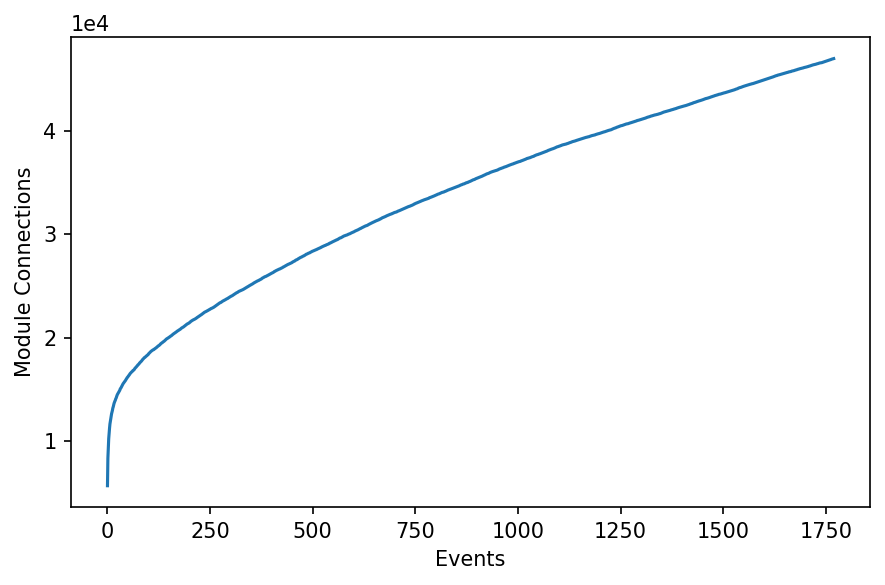

In [35]:
fig = plt.figure(dpi=150, figsize=(6,4))
plt.plot(np.arange(0,len(evtids),1), total_connections)
plt.xlabel('Events')
plt.ylabel('Module Connections')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.tight_layout()

(0, 1)
(1, 2)
(2, 3)
(0, 10)
(1, 10)
(2, 10)
(4, 5)
(5, 6)
(6, 7)
(7, 8)
(8, 9)
(9, 10)
(0, 11)
(1, 11)
(2, 11)
(11, 12)
(12, 13)
(13, 14)
(14, 15)
(15, 16)
(16, 17)


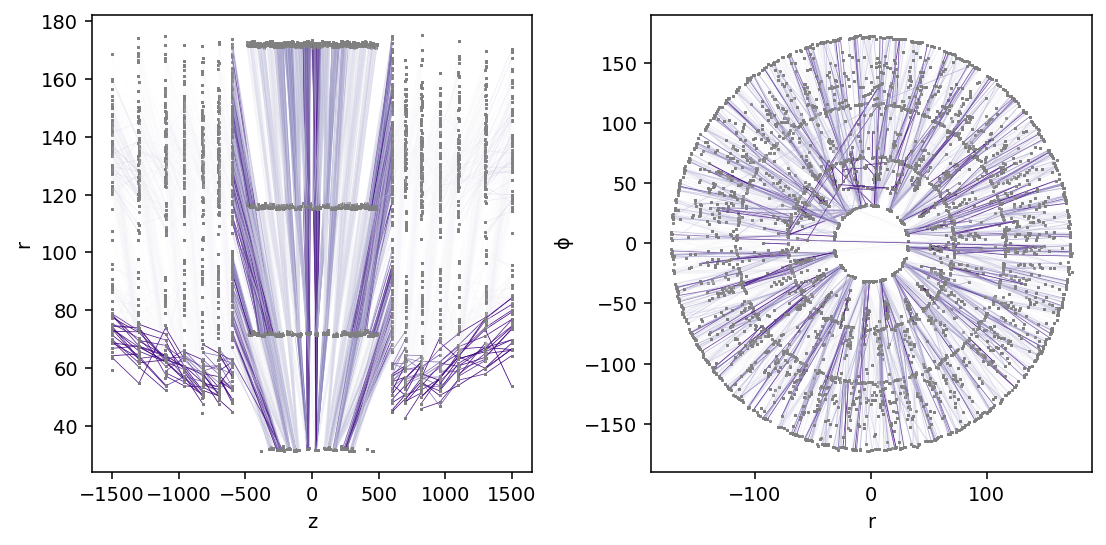

In [42]:
from matplotlib import cm 

max_counts = []
for lp in layer_pairs:
    module_map = module_maps[lp]
    max_counts.append(np.max(module_map))
max_count = np.max(max_counts)

hits_by_loc = hits.groupby('layer')

fig, axs = plt.subplots(nrows=1, ncols=2, dpi=140, figsize=(8,4))
cmap = cm.get_cmap('Purples', 25)
for lp in layer_pairs:

    hits0 = hits_by_loc.get_group(lp[0])
    hits1 = hits_by_loc.get_group(lp[1])
    keys = ['evtid', 'particle_id', 'module_id', 'r', 'phi', 'z']
    hit_pairs = hits0[keys].reset_index().merge(
    hits1[keys].reset_index(), on='evtid', suffixes=('_1', '_2'))
    pid1, pid2 = hit_pairs['particle_id_1'], hit_pairs['particle_id_2']
    hit_pairs = hit_pairs[pid1==pid2]
    mid1, mid2 = hit_pairs['module_id_1'].values, hit_pairs['module_id_2'].values
    r1, r2 = hit_pairs['r_1'], hit_pairs['r_2']
    p1, p2 = hit_pairs['phi_1'], hit_pairs['phi_2']
    z1, z2 = hit_pairs['z_1'], hit_pairs['z_2']
    
    module_map = module_maps[lp]
    max_count = np.max(module_map)
    print(lp)
    for i in np.unique(mid1):
        for j in np.unique(mid2):
            if module_map[(i,j)] == 0: continue
            r1avg = np.mean(r1[mid1==i])
            r2avg = np.mean(r2[mid2==j])
            p1avg = np.mean(p1[mid1==i])
            p2avg = np.mean(p2[mid2==j])
            z1avg = np.mean(z1[mid1==i])
            z2avg = np.mean(z2[mid2==j])
            weight = module_map[(i,j)]/max_count
            axs[0].plot((z1avg, z2avg), (r1avg, r2avg),
                         marker='o', ls='-', color=cmap(weight), 
                         lw=0.4, ms=0.1, alpha=weight)
            axs[1].plot((r1avg*np.cos(p1avg), r2avg*np.cos(p2avg)), 
                        (r1avg*np.sin(p1avg), r2avg*np.sin(p2avg)),
                         marker='o', ls='-', color=cmap(weight), 
                         lw=0.4, ms=0.1, alpha=weight)
           
            axs[0].plot(z1avg, r1avg, marker='o', ms=0.4, color='grey')
            axs[0].plot(z2avg, r2avg, marker='o', ms=0.4, color='grey')
            axs[1].plot(r1avg*np.cos(p1avg), r1avg*np.sin(p1avg), marker='o', ms=0.4, color='grey')
            axs[1].plot(r2avg*np.cos(p2avg), r2avg*np.sin(p2avg), marker='o', ms=0.4, color='grey')
    
axs[0].set_xlabel('z')
axs[0].set_ylabel('r')
axs[1].set_xlabel('r')
axs[1].set_ylabel('$\phi$')
plt.tight_layout()
plt.show()

In [38]:
with open('module_map_1.npy', 'wb') as f:
    np.save(f, module_maps)